<a href="https://colab.research.google.com/github/chaitanyya007/major_project_118/blob/main/base_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Grover Adaptive Search (GAS) for VRP using PennyLane (local simulator)
# - No IBM or remote backends
# - Builds oracle & diffusion as full unitaries (suitable for small problem sizes)
# - Measures runtime and memory usage per test case
#
# Usage: change test_cases below or add more, then run the script.

import time
import math
import itertools
import psutil
import os
import numpy as np
import pennylane as qml

# ----------------------------
# Utility: VRP classical helpers
# ----------------------------
def route_cost(route, dist):
    """Cost of a given route (sequence of city indices, excluding depot index 0)."""
    if not route:
        return 0
    s = dist[0, route[0]]
    for i in range(len(route) - 1):
        s += dist[route[i], route[i+1]]
    s += dist[route[-1], 0]
    return s

def total_cost(sol, dist):
    """Total cost for a tuple (perm_vehicle1, perm_vehicle2, ...)."""
    return sum(route_cost(route, dist) for route in sol)

def enumerate_complete_solutions(num_customers, num_vehicles):
    """
    Enumerate all partitions of the customers {1..num_customers} into num_vehicles ordered
    routes (each route is a permutation of the assigned customers).
    Returns a list of tuples: (perm_v1, perm_v2, ..., perm_vK) where each perm is a tuple of customer indices.
    NOTE: customers are expected to be indexed 1..num_customers (0 reserved for depot).
    """
    city_idx = list(range(1, num_customers + 1))
    solutions = []
    # Partition by bitmask approach for 2 vehicles generalizes poorly to >2 vehicles.
    # We'll use an approach that assigns each customer to one of the vehicles (vehicle assignment),
    # then enumerate permutations for each vehicle's assigned customers.
    # Caution: this generates duplicates when vehicles are indistinguishable, but that's okay here.
    assignments = itertools.product(range(num_vehicles), repeat=num_customers)  # num_vehicles^num_customers
    for assign in assignments:
        groups = [[] for _ in range(num_vehicles)]
        for cust_idx, v in enumerate(assign):
            # cust ID = cust_idx+1
            groups[v].append(cust_idx + 1)
        # permutations for each group
        perms_list = []
        for g in groups:
            if g:
                perms_list.append(list(itertools.permutations(g)))
            else:
                perms_list.append([()])  # empty route represented as empty tuple
        # Cartesian product of permutations across vehicles
        for combo in itertools.product(*perms_list):
            solutions.append(tuple(combo))
    return solutions

# ----------------------------
# GAS using PennyLane
# ----------------------------
def build_oracle_matrix(N_states, optimal_indices):
    """
    Build a diagonal oracle matrix U_w of size (N_states x N_states) that
    multiplies optimal (marked) basis states by -1 and leaves others unchanged.
    """
    diag = np.ones(N_states, dtype=complex)
    for idx in optimal_indices:
        diag[idx] = -1.0 + 0.0j
    return np.diag(diag)

def build_diffusion_matrix(N_states):
    """
    Diffusion operator D = 2|s><s| - I where |s> is uniform over N_states.
    Build as a dense matrix.
    """
    s = np.ones((N_states, 1), dtype=complex) / math.sqrt(N_states)
    projector = 2.0 * (s @ s.conj().T)
    return projector - np.eye(N_states, dtype=complex)

def run_gas_for_case(customers, dist_matrix, num_vehicles=2, shots=2048):
    """
    Run GAS for a VRP instance defined by customers and dist_matrix.
    Returns: (decoded_solution_tuple, classical_cost, timing_seconds, mem_MB, counts_dict)
    """
    # 1) enumerate solutions
    num_customers = len(customers)
    solutions = enumerate_complete_solutions(num_customers, num_vehicles)
    N = len(solutions)
    if N == 0:
        raise ValueError("No solutions generated (check inputs).")

    # compute costs
    costs = [total_cost(sol, dist_matrix) for sol in solutions]
    min_cost = min(costs)
    optimal_indices = [i for i, c in enumerate(costs) if np.isclose(c, min_cost)]

    # decide number of data qubits
    n_data_qubits = math.ceil(math.log2(N))
    N_states = 2 ** n_data_qubits

    # Build oracle and diffusion matrices (size N_states x N_states)
    oracle = build_oracle_matrix(N_states, optimal_indices)
    diffusion = build_diffusion_matrix(N_states)

    # Build PennyLane device and qnode
    dev = qml.device("default.qubit", wires=n_data_qubits, shots=shots)

    # We'll construct a qnode that:
    # - prepares uniform superposition on first n_data_qubits
    # - applies r iterations of (oracle, diffusion) using qml.QubitUnitary
    # - measures computational basis samples
    r = max(1, int(math.floor((math.pi/4) * math.sqrt(N_states / max(1, len(optimal_indices))))))
    # cap iterations moderately to avoid huge circuits
    r = min(r, 30)

    # Put matrices into np.array (complex) for QubitUnitary
    oracle_mat = np.array(oracle, dtype=complex)
    diffusion_mat = np.array(diffusion, dtype=complex)

    @qml.qnode(dev)
    def grover_circuit():
        # uniform superposition
        for i in range(n_data_qubits):
            qml.Hadamard(wires=i)
        # iterate
        for _ in range(r):
            qml.QubitUnitary(oracle_mat, wires=range(n_data_qubits))
            qml.QubitUnitary(diffusion_mat, wires=range(n_data_qubits))
        # sample computational basis
        return qml.sample(wires=list(range(n_data_qubits)))

    # measure time + memory
    proc = psutil.Process(os.getpid())
    mem_before = proc.memory_info().rss / (1024.0 * 1024.0)
    t0 = time.time()
    samples = grover_circuit()  # shape (shots, n_data_qubits) as array of 0/1 ints
    t1 = time.time()
    mem_after = proc.memory_info().rss / (1024.0 * 1024.0)
    time_taken = t1 - t0
    mem_used_mb = mem_after  # you can also compute delta if desired

    # convert each sample bitstring to integer index (msb is last wire by default ordering)
    # PennyLane's sample returns arrays with wires in increasing order; convert to bitstring by MSB->LSB ordering
    # We'll interpret wire 0 as most significant bit for consistency with integer mapping used earlier:
    # convert sample bits (array) to integer index
    counts = {}
    samples = np.array(samples)
    for s in samples:
        # s is array of bits length n_data_qubits; choose bit-order consistent with matrix indexing
        # We'll treat s[0] as wire 0 (most significant) -> index = sum(s[i] * 2^(n-i-1))
        idx = 0
        for i, b in enumerate(s):
            idx = (idx << 1) | int(b)
        counts[idx] = counts.get(idx, 0) + 1

    # find most frequent valid state (index < N)
    sorted_counts = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)
    most_valid = None
    for bs_idx, cnt in sorted_counts:
        if bs_idx < N:
            most_valid = (bs_idx, cnt)
            break

    if most_valid is not None:
        chosen_idx, cnt = most_valid
        chosen_solution = solutions[chosen_idx]
        chosen_cost = costs[chosen_idx]
    else:
        chosen_idx, cnt = None, 0
        chosen_solution, chosen_cost = None, None

    # package counts as human-friendly mapping for indices < N
    filtered_counts = {idx: c for idx, c in counts.items() if idx < N}

    result = {
        "N_states": N_states,
        "n_data_qubits": n_data_qubits,
        "num_solutions": N,
        "num_optimal": len(optimal_indices),
        "optimal_indices": optimal_indices,
        "chosen_index": chosen_idx,
        "chosen_solution": chosen_solution,
        "chosen_cost": chosen_cost,
        "counts": filtered_counts,
        "time_s": time_taken,
        "mem_mb": mem_used_mb,
        "grover_iterations": r
    }
    return result

# ----------------------------
# Convenience: pretty-print a solution
# ----------------------------
def format_solution(sol):
    return tuple(tuple(route) for route in sol)

# ----------------------------
# Example test cases
# ----------------------------
if __name__ == "__main__":
    # Example VRP definitions (small: enumerative GAS feasible)
    # You can add more cases to the list; keep total solutions small (e.g., <= 2^16) for full-unitary approach.
    test_cases = [
        # case 1: 2 vehicles, 4 customers (like your earlier qiskit example)
        {
            "customers": ["Depot", "A", "B", "C", "D"],
            "city_idx": [1,2,3,4],
            "dist": np.array([[0,10,15,20,25],[10,0,35,25,30],[15,35,0,30,5],[20,25,30,0,15],[25,30,5,15,0]])
        },
        # case 2: 3 customers, 2 vehicles (tiny test)
        {
            "customers": ["Depot","A","B","C"],
            "city_idx": [1,2,3],
            "dist": np.array([[0,5,6,7],[5,0,4,3],[6,4,0,2],[7,3,2,0]])
        },
        # Add your own small scenarios below if desired
    ]

    # Run GAS for each case and print results
    all_times = []
    all_mems = []
    for i, case in enumerate(test_cases, start=1):
        cities = case["customers"]
        city_idx = case["city_idx"]
        dist_matrix = case["dist"]
        num_customers = len(city_idx)
        # We'll map the enumerate function to use num_customers & 2 vehicles for demonstration
        print(f"\n=== Test case {i}: {len(city_idx)} customers (excluding depot) ===")
        res = run_gas_for_case(customers=city_idx, dist_matrix=dist_matrix, num_vehicles=2, shots=1024)

        print(f"Data qubits: {res['n_data_qubits']}  total states: {res['N_states']}")
        print(f"Number of enumerated solutions: {res['num_solutions']}")
        print(f"Number of optimal solutions (classical): {res['num_optimal']}")
        print(f"Optimal solution indices (classical): {res['optimal_indices']}")
        if res["chosen_solution"] is not None:
            print(f"Most frequent valid measured index: {res['chosen_index']}  (counts={res['counts'].get(res['chosen_index'],0)})")
            print("Decoded solution (vehicle routes):", format_solution(res["chosen_solution"]))
            print(f"Classical total cost for that solution: {res['chosen_cost']}")
        else:
            print("No valid measured state observed.")

        print(f"Grover iterations used: {res['grover_iterations']}")
        print(f"Time for quantum circuit execution (s): {res['time_s']:.4f}")
        print(f"Memory (RSS) at measurement (MB): {res['mem_mb']:.1f}")

        all_times.append(res["time_s"])
        all_mems.append(res["mem_mb"])

    if all_times:
        print("\n=== Summary across test cases ===")
        print(f"Average time (s): {np.mean(all_times):.4f}, min: {np.min(all_times):.4f}, max: {np.max(all_times):.4f}")
        print(f"Average memory (MB): {np.mean(all_mems):.1f}, min: {np.min(all_mems):.1f}, max: {np.max(all_mems):.1f}")



=== Test case 1: 4 customers (excluding depot) ===
Data qubits: 7  total states: 128
Number of enumerated solutions: 120
Number of optimal solutions (classical): 4
Optimal solution indices (classical): [3, 11, 99, 107]
Most frequent valid measured index: 99  (counts=277)
Decoded solution (vehicle routes): ((), (1, 3, 4, 2))
Classical total cost for that solution: 70
Grover iterations used: 4
Time for quantum circuit execution (s): 0.0199
Memory (RSS) at measurement (MB): 316.0

=== Test case 2: 3 customers (excluding depot) ===
Data qubits: 5  total states: 32
Number of enumerated solutions: 24
Number of optimal solutions (classical): 4
Optimal solution indices (classical): [1, 3, 19, 21]
Most frequent valid measured index: 1  (counts=248)
Decoded solution (vehicle routes): ((1, 3, 2), ())
Classical total cost for that solution: 16
Grover iterations used: 2
Time for quantum circuit execution (s): 0.0032
Memory (RSS) at measurement (MB): 316.0

=== Summary across test cases ===
Average

/usr/local/lib/python3.12/dist-packages/pennylane/devices/device_api.py:193: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(


In [ ]:
pip install pennylane pennylane-lightning torch numpy matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 118.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 15.9 MB/s eta 0:00:00


In [ ]:
pip install qiskit qiskit-aer numpy matplotlib psutil


In [ ]:
!pip install qiskit qiskit-aer


In [ ]:
!pip install qiskit qiskit-aer --upgrade



=== Test case 1: 4 customers, 2 vehicles ===


/tmp/ipython-input-1101208605.py:93: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(controls, target, ancilla_qubits, mode='basic')
/tmp/ipython-input-1101208605.py:93: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(controls, target, ancilla_qubits, mode='basic')
/tmp/ipython-input-1

Data qubits: 7  (search states: 128)
Enumerated solutions: 120
Classical optimal indices: [3, 11, 99, 107]
Most frequently measured valid index: 99 counts: 268
Decoded solution (vehicle routes): ((), ('A', 'C', 'D', 'B'))
Classical cost of that solution: 70
Grover iterations used: 4
Circuit depth: 741, gate count (size): 820
Quantum execution time (s): 0.0639
Memory RSS (MB): 147.6


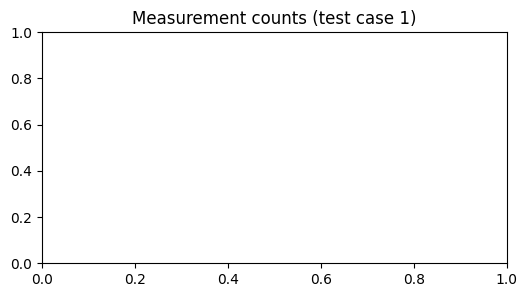


=== Test case 2: 3 customers, 2 vehicles ===


/tmp/ipython-input-1101208605.py:93: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(controls, target, ancilla_qubits, mode='basic')
/tmp/ipython-input-1101208605.py:93: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(controls, target, ancilla_qubits, mode='basic')
/tmp/ipython-input-1

Data qubits: 5  (search states: 32)
Enumerated solutions: 24
Classical optimal indices: [1, 3, 19, 21]
Most frequently measured valid index: 21 counts: 244
Decoded solution (vehicle routes): ((), ('B', 'C', 'A'))
Classical cost of that solution: 16
Grover iterations used: 2
Circuit depth: 157, gate count (size): 188
Quantum execution time (s): 0.0203
Memory RSS (MB): 153.4


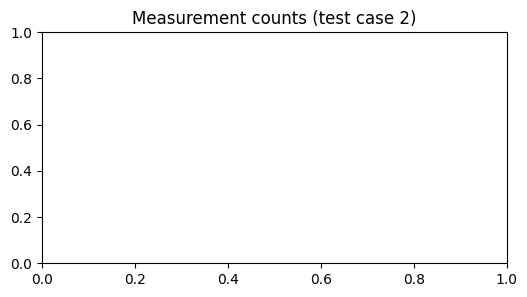


=== Summary ===
Avg time (s): 0.0421, min: 0.0203, max: 0.0639
Avg memory (MB): 150.5, min: 147.6, max: 153.4


In [ ]:
# Grover Adaptive Search (GAS) for VRP — Gate-based Qiskit implementation (local simulator)
# - No IBM cloud / API usage
# - Gate-level oracle using multi-controlled-X (mcx) to implement multi-controlled phase flips
# - Suitable for small enumerated VRP instances used in demonstrations
#
# Requirements:
#   pip install qiskit psutil matplotlib numpy
#
# Usage:
#   Edit the `test_cases` list below (small instances only) and run the script.
#   Keep the number of total enumerated solutions manageable (2^n_qubits should be <= a few thousand).

import math
import itertools
import time
import os
import psutil
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# ----------------------------
# Classical VRP helpers
# ----------------------------
def route_cost(route, dist):
    if not route:
        return 0
    s = dist[0, route[0]]
    for i in range(len(route) - 1):
        s += dist[route[i], route[i + 1]]
    s += dist[route[-1], 0]
    return s

def total_cost(sol, dist):
    return sum(route_cost(route, dist) for route in sol)

def enumerate_complete_solutions(num_customers, num_vehicles):
    """
    Enumerate all assignments of customers {1..num_customers} to vehicles (0..num_vehicles-1),
    then all permutations of each vehicle's assigned customers.
    Returns list of tuples (perm_v0, perm_v1, ..., perm_vK-1)
    """
    city_idx = list(range(1, num_customers + 1))
    solutions = []
    # assignments: cartesian product of vehicles for each customer
    for assign in itertools.product(range(num_vehicles), repeat=num_customers):
        groups = [[] for _ in range(num_vehicles)]
        for cust_idx, v in enumerate(assign):
            groups[v].append(cust_idx + 1)
        perms_list = []
        for g in groups:
            if g:
                perms_list.append(list(itertools.permutations(g)))
            else:
                perms_list.append([()])  # empty route
        for combo in itertools.product(*perms_list):
            solutions.append(tuple(combo))
    return solutions

# ----------------------------
# Quantum building blocks
# ----------------------------
def build_gate_oracle(qc, data_qubits, ancilla_qubits, marked_index, n_data_qubits):
    """
    For a single marked_index (integer between 0 and N_states-1), convert to bitstring and apply
    phase flip (-1) for that computational basis state using multi-controlled-Z (via mcx).
    This function mutates qc in-place.
    """
    # Represent index as bitstring MSB..LSB length n_data_qubits
    bitstr = format(marked_index, f'0{n_data_qubits}b')
    # Step 1: apply X gates to qubits where bit is '0' (so marked state's bits become all 1)
    for i, b in enumerate(bitstr):
        if b == '0':
            qc.x(data_qubits[i])
    # Step 2: apply multi-controlled Z (implement via H + multi-controlled X)
    # If only 1 qubit, simply apply Z
    if n_data_qubits == 1:
        qc.z(data_qubits[0])
    else:
        # use last data qubit as target for mcx (we'll wrap with H to convert to mcz)
        target = data_qubits[-1]
        controls = data_qubits[:-1]
        qc.h(target)
        if len(controls) == 1:
            # Controlled-X is cx
            qc.cx(controls[0], target)
        else:
            # Use mcx (multi-controlled X). Provide ancillas if available.
            if ancilla_qubits:
                qc.mcx(controls, target, ancilla_qubits, mode='basic')
            else:
                # If no ancillas, use 'noancilla' mode (works for small control counts)
                qc.mcx(controls, target)
        qc.h(target)
    # Step 3: undo previous X gates
    for i, b in enumerate(bitstr):
        if b == '0':
            qc.x(data_qubits[i])

def build_diffusion(qc, data_qubits, ancilla_qubits):
    """
    Build the Grover diffusion operator on the data_qubits using H/X/mcx/H pattern.
    Mutates qc in-place.
    """
    n = len(data_qubits)
    if n == 0:
        return
    # H on all
    for q in data_qubits:
        qc.h(q)
    # X on all
    for q in data_qubits:
        qc.x(q)
    # multi-controlled Z on all qubits -> implement as H + mcx
    if n == 1:
        qc.z(data_qubits[0])
    else:
        target = data_qubits[-1]
        controls = data_qubits[:-1]
        qc.h(target)
        if len(controls) == 1:
            qc.cx(controls[0], target)
        else:
            if ancilla_qubits:
                qc.mcx(controls, target, ancilla_qubits, mode='basic')
            else:
                qc.mcx(controls, target)
        qc.h(target)
    # X on all
    for q in data_qubits:
        qc.x(q)
    # H on all
    for q in data_qubits:
        qc.h(q)

# ----------------------------
# GAS via gate-based circuits
# ----------------------------
def run_gate_gas(num_customers, dist_matrix, num_vehicles=2, shots=1024):
    """
    - Enumerates solutions
    - Builds gate-based Grover circuit (oracle implemented by marking optimal classical solutions)
    - Runs on AerSimulator
    Returns a dictionary with results and stats.
    """
    # 1) enumerations
    solutions = enumerate_complete_solutions(num_customers, num_vehicles)
    N = len(solutions)
    if N == 0:
        raise ValueError("No solutions generated.")
    costs = [total_cost(sol, dist_matrix) for sol in solutions]
    min_cost = min(costs)
    optimal_indices = [i for i, c in enumerate(costs) if math.isclose(c, min_cost)]
    # 2) determine data qubits
    n_data_qubits = math.ceil(math.log2(N))
    N_states = 2 ** n_data_qubits

    # ancilla count recommended for mcx:
    # For MCX in 'basic' mode, ancilla count should be >= n_controls - 2
    ancilla_qubits = max(0, n_data_qubits - 2)
    total_qubits = n_data_qubits + ancilla_qubits

    # create quantum circuit with measurement register mapping data qubits to classical bits
    qc = QuantumCircuit(total_qubits, n_data_qubits)

    data_qubits = list(range(n_data_qubits))
    ancillas = list(range(n_data_qubits, total_qubits)) if ancilla_qubits > 0 else []

    # 3) initial uniform superposition on data qubits
    for q in data_qubits:
        qc.h(q)

    # compute number of marked states M and Grover iterations r
    M = max(1, len(optimal_indices))
    # approximate optimal iterations
    r = max(1, int(math.floor((math.pi / 4) * math.sqrt(N_states / M))))
    r = min(r, 30)  # safety cap
    # 4) Grover iterations: apply oracle (for all optimal indices) then diffusion
    for _ in range(r):
        # Oracle marking all optimal_indices (apply sequence of phase flips)
        for opt_idx in optimal_indices:
            build_gate_oracle(qc, data_qubits, ancillas, opt_idx, n_data_qubits)
        # Diffusion
        build_diffusion(qc, data_qubits, ancillas)

    # 5) measurement of data qubits (map data_qubits[i] -> classical bit i)
    for i, q in enumerate(data_qubits):
        qc.measure(q, i)

    # 6) run on AerSimulator
    backend = AerSimulator()
    # transpile for backend
    tqc = transpile(qc, backend=backend, optimization_level=2)
    # measure circuit stats
    depth = tqc.depth()
    size = tqc.size()  # number of gates

    # time & memory
    proc = psutil.Process(os.getpid())
    mem_before = proc.memory_info().rss / (1024 * 1024)
    t0 = time.time()
    job = backend.run(tqc, shots=shots)
    result = job.result()
    t1 = time.time()
    mem_after = proc.memory_info().rss / (1024 * 1024)
    time_taken = t1 - t0
    mem_used_mb = mem_after

    counts = result.get_counts(qc)
    # interpret measured bitstrings (Qiskit returns bitstrings with least-significant bit = last measured)
    # Our mapping used classical bit i <- data_qubit i, so bitstring ordering is e.g. 'b_{n-1}...b_0' depending on backend.
    # We'll convert each bitstring to integer by interpreting the string with leftmost char as MSB.
    converted_counts = {}
    for bitstr, cnt in counts.items():
        # remove spaces, convert to integer MSB..LSB
        bs = bitstr.replace(" ", "")
        # Qiskit returns bitstring with qubit 0 as leftmost (classical bit 0), so it's already MSB->LSB mapping as we measured.
        try:
            idx = int(bs, 2)
        except ValueError:
            # fallback: reverse
            idx = int(bs[::-1], 2)
        converted_counts[idx] = converted_counts.get(idx, 0) + cnt

    # find most frequent valid state < N
    sorted_counts = sorted(converted_counts.items(), key=lambda kv: kv[1], reverse=True)
    most_valid = None
    for idx, cnt in sorted_counts:
        if idx < N:
            most_valid = (idx, cnt)
            break

    chosen_idx = most_valid[0] if most_valid else None
    chosen_solution = solutions[chosen_idx] if chosen_idx is not None else None
    chosen_cost = costs[chosen_idx] if chosen_idx is not None else None

    res = {
        "n_data_qubits": n_data_qubits,
        "N_states": N_states,
        "num_solutions": N,
        "optimal_indices": optimal_indices,
        "chosen_index": chosen_idx,
        "chosen_solution": chosen_solution,
        "chosen_cost": chosen_cost,
        "counts": converted_counts,
        "time_s": time_taken,
        "mem_mb": mem_used_mb,
        "depth": depth,
        "size": size,
        "grover_iterations": r,
        "circuit": tqc,
        "qc_raw": qc
    }
    return res

# ----------------------------
# Helper for pretty printing solution
# ----------------------------
def format_solution(sol, city_names=None):
    if sol is None:
        return None
    if city_names:
        def conv(route):
            return tuple(city_names[c] for c in route)
        return tuple(conv(r) for r in sol)
    else:
        return tuple(tuple(r) for r in sol)

# ----------------------------
# Example usage & small test cases
# ----------------------------
if __name__ == "__main__":
    # keep test sizes small
    test_cases = [
        # 4 customers (A-D), 2 vehicles
        {
            "city_names": ["Depot", "A", "B", "C", "D"],
            "num_customers": 4,
            "dist": np.array([
                [0,10,15,20,25],
                [10,0,35,25,30],
                [15,35,0,30,5],
                [20,25,30,0,15],
                [25,30,5,15,0]
            ]),
            "num_vehicles": 2
        },
        # 3 customers, 2 vehicles (tiny)
        {
            "city_names": ["Depot","A","B","C"],
            "num_customers": 3,
            "dist": np.array([
                [0,5,6,7],
                [5,0,4,3],
                [6,4,0,2],
                [7,3,2,0]
            ]),
            "num_vehicles": 2
        }
    ]

    all_times = []
    all_mems = []

    for i, case in enumerate(test_cases, start=1):
        print(f"\n=== Test case {i}: {case['num_customers']} customers, {case['num_vehicles']} vehicles ===")
        res = run_gate_gas(case["num_customers"], case["dist"], num_vehicles=case["num_vehicles"], shots=1024)

        print(f"Data qubits: {res['n_data_qubits']}  (search states: {res['N_states']})")
        print(f"Enumerated solutions: {res['num_solutions']}")
        print(f"Classical optimal indices: {res['optimal_indices']}")
        if res["chosen_solution"] is not None:
            print("Most frequently measured valid index:", res["chosen_index"], "counts:", res["counts"].get(res["chosen_index"], 0))
            print("Decoded solution (vehicle routes):", format_solution(res["chosen_solution"], case["city_names"]))
            print("Classical cost of that solution:", res["chosen_cost"])
        else:
            print("No valid measured state observed.")

        print(f"Grover iterations used: {res['grover_iterations']}")
        print(f"Circuit depth: {res['depth']}, gate count (size): {res['size']}")
        print(f"Quantum execution time (s): {res['time_s']:.4f}")
        print(f"Memory RSS (MB): {res['mem_mb']:.1f}")

        # show histogram (small)
        plt.figure(figsize=(6,3))
        plot_histogram(res["counts"])
        plt.title(f"Measurement counts (test case {i})")
        plt.show()

        all_times.append(res["time_s"])
        all_mems.append(res["mem_mb"])

    if all_times:
        print("\n=== Summary ===")
        print(f"Avg time (s): {np.mean(all_times):.4f}, min: {np.min(all_times):.4f}, max: {np.max(all_times):.4f}")
        print(f"Avg memory (MB): {np.mean(all_mems):.1f}, min: {np.min(all_mems):.1f}, max: {np.max(all_mems):.1f}")


In [ ]:
from qiskit_aer import AerSimulator
sim = AerSimulator()
print("✅ AerSimulator loaded successfully.")


✅ AerSimulator loaded successfully.



=== Test case 1: 1 customers, 1 vehicles ===
Data qubits: 0  (search states: 1)
Enumerated solutions: 1
Classical optimal indices: [0]
Most frequently measured valid index: 0
Decoded solution (vehicle routes): (('A',),)
Classical cost of that solution: 2
Grover iterations used: 0
Circuit depth: 0, gate count (size): 0
Quantum execution time (s): 0.0000


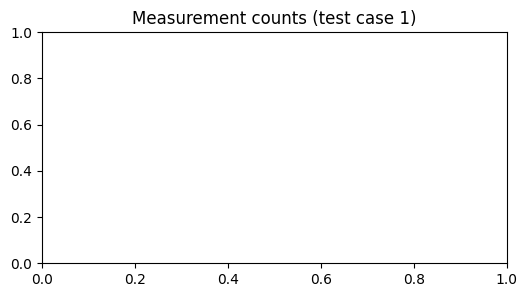


=== Test case 2: 2 customers, 1 vehicles ===
Data qubits: 1  (search states: 2)
Enumerated solutions: 2
Classical optimal indices: [0, 1]
Most frequently measured valid index: 1
Decoded solution (vehicle routes): (('B', 'A'),)
Classical cost of that solution: 4
Grover iterations used: 1
Circuit depth: 2, gate count (size): 2
Quantum execution time (s): 0.0031


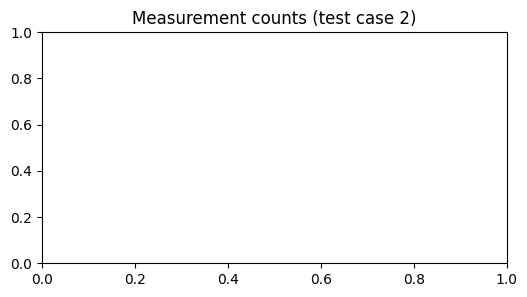


=== Test case 3: 3 customers, 1 vehicles ===
Data qubits: 3  (search states: 8)
Enumerated solutions: 6
Classical optimal indices: [0, 1, 2, 3, 4, 5]
Most frequently measured valid index: 3
Decoded solution (vehicle routes): (('B', 'C', 'A'),)
Classical cost of that solution: 10
Grover iterations used: 1
Circuit depth: 16, gate count (size): 27
Quantum execution time (s): 0.0037


/tmp/ipython-input-1592538764.py:74: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(controls, target, ancilla_qubits, mode='basic')
/tmp/ipython-input-1592538764.py:100: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(controls, target, ancilla_qubits, mode='basic')


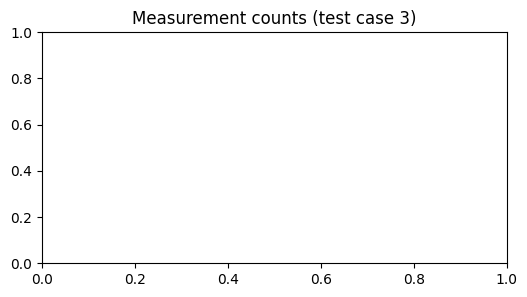


=== Test case 4: 3 customers, 2 vehicles ===
Data qubits: 5  (search states: 32)
Enumerated solutions: 24
Classical optimal indices: [0, 5, 18, 23]
Most frequently measured valid index: 9
Decoded solution (vehicle routes): (('C', 'A'), ('B',))
Classical cost of that solution: 16
Grover iterations used: 2
Circuit depth: 173, gate count (size): 213
Quantum execution time (s): 0.0094


/tmp/ipython-input-1592538764.py:74: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(controls, target, ancilla_qubits, mode='basic')
/tmp/ipython-input-1592538764.py:74: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(controls, target, ancilla_qubits, mode='basic')
/tmp/ipython-input-1

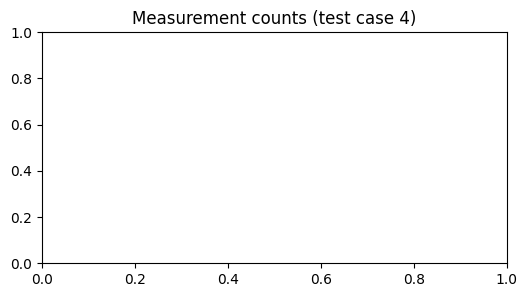


=== Test case 5: 4 customers, 2 vehicles ===


/tmp/ipython-input-1592538764.py:74: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(controls, target, ancilla_qubits, mode='basic')
/tmp/ipython-input-1592538764.py:74: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(controls, target, ancilla_qubits, mode='basic')
/tmp/ipython-input-1

Data qubits: 7  (search states: 128)
Enumerated solutions: 120
Classical optimal indices: [2, 8, 19, 21, 98, 104, 115, 117]
Most frequently measured valid index: 35
Decoded solution (vehicle routes): (('D', 'B', 'A'), ('C',))
Classical cost of that solution: 19
Grover iterations used: 3
Circuit depth: 821, gate count (size): 925
Quantum execution time (s): 0.0433


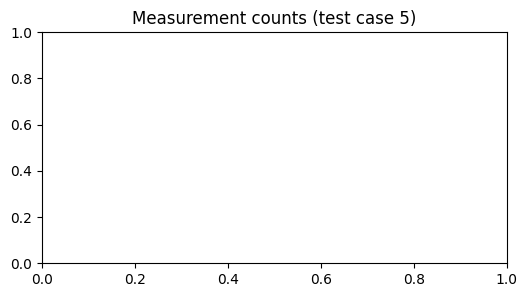


=== Test case 6: 5 customers, 1 vehicles ===


/tmp/ipython-input-1592538764.py:74: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(controls, target, ancilla_qubits, mode='basic')
/tmp/ipython-input-1592538764.py:74: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(controls, target, ancilla_qubits, mode='basic')
/tmp/ipython-input-1

Data qubits: 7  (search states: 128)
Enumerated solutions: 120
Classical optimal indices: [0, 1, 3, 5, 9, 11, 17, 23, 33, 35, 41, 47, 65, 71, 95, 119]
Most frequently measured valid index: 64
Decoded solution (vehicle routes): (('C', 'D', 'E', 'A', 'B'),)
Classical cost of that solution: 21
Grover iterations used: 2
Circuit depth: 789, gate count (size): 873
Quantum execution time (s): 0.0377


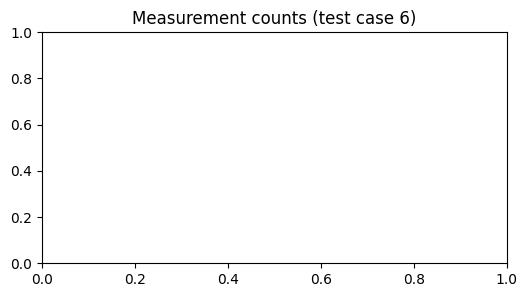


=== Test case 7: 5 customers, 2 vehicles ===


/tmp/ipython-input-1592538764.py:74: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(controls, target, ancilla_qubits, mode='basic')
/tmp/ipython-input-1592538764.py:74: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(controls, target, ancilla_qubits, mode='basic')
/tmp/ipython-input-1

Data qubits: 10  (search states: 1024)
Enumerated solutions: 720
Classical optimal indices: [0, 1, 3, 5, 9, 11, 17, 23, 33, 35, 41, 47, 65, 71, 95, 119, 600, 601, 603, 605, 609, 611, 617, 623, 633, 635, 641, 647, 665, 671, 695, 719]
Most frequently measured valid index: 0
Decoded solution (vehicle routes): (('A', 'B', 'C', 'D', 'E'), ())
Classical cost of that solution: 22
Grover iterations used: 4
Circuit depth: 3649, gate count (size): 3928
Quantum execution time (s): 2.0686


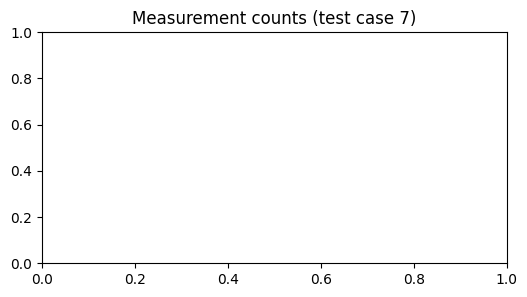

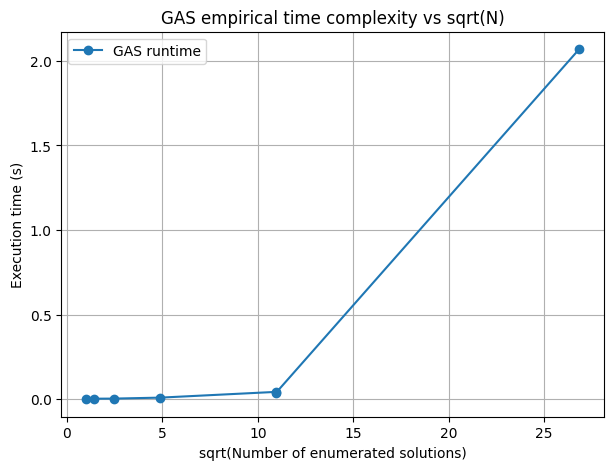

In [ ]:
# Grover Adaptive Search (GAS) for VRP — Gate-based Qiskit implementation (local simulator)
# - No IBM cloud / API usage
# - Gate-level oracle using multi-controlled-X (mcx) to implement multi-controlled phase flips
# - Suitable for small enumerated VRP instances used in demonstrations
#
# Requirements:
#   pip install qiskit psutil matplotlib numpy
#
# Usage:
#   Edit the `test_cases` list below (small instances only) and run the script.
#   Keep the number of total enumerated solutions manageable (2^n_qubits should be <= a few thousand).

import math
import itertools
import time
import os
import psutil
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# ----------------------------
# Classical VRP helpers
# ----------------------------
def route_cost(route, dist):
    if not route:
        return 0
    s = dist[0, route[0]]
    for i in range(len(route) - 1):
        s += dist[route[i], route[i + 1]]
    s += dist[route[-1], 0]
    return s

def total_cost(sol, dist):
    return sum(route_cost(route, dist) for route in sol)

def enumerate_complete_solutions(num_customers, num_vehicles):
    city_idx = list(range(1, num_customers + 1))
    solutions = []
    for assign in itertools.product(range(num_vehicles), repeat=num_customers):
        groups = [[] for _ in range(num_vehicles)]
        for cust_idx, v in enumerate(assign):
            groups[v].append(cust_idx + 1)
        perms_list = []
        for g in groups:
            if g:
                perms_list.append(list(itertools.permutations(g)))
            else:
                perms_list.append([()])  # empty route
        for combo in itertools.product(*perms_list):
            solutions.append(tuple(combo))
    return solutions

# ----------------------------
# Quantum building blocks
# ----------------------------
def build_gate_oracle(qc, data_qubits, ancilla_qubits, marked_index, n_data_qubits):
    bitstr = format(marked_index, f'0{n_data_qubits}b')
    for i, b in enumerate(bitstr):
        if b == '0':
            qc.x(data_qubits[i])
    if n_data_qubits == 1:
        qc.z(data_qubits[0])
    else:
        target = data_qubits[-1]
        controls = data_qubits[:-1]
        qc.h(target)
        if len(controls) == 1:
            qc.cx(controls[0], target)
        else:
            if ancilla_qubits:
                qc.mcx(controls, target, ancilla_qubits, mode='basic')
            else:
                qc.mcx(controls, target)
        qc.h(target)
    for i, b in enumerate(bitstr):
        if b == '0':
            qc.x(data_qubits[i])

def build_diffusion(qc, data_qubits, ancilla_qubits):
    n = len(data_qubits)
    if n == 0:
        return
    for q in data_qubits:
        qc.h(q)
    for q in data_qubits:
        qc.x(q)
    if n == 1:
        qc.z(data_qubits[0])
    else:
        target = data_qubits[-1]
        controls = data_qubits[:-1]
        qc.h(target)
        if len(controls) == 1:
            qc.cx(controls[0], target)
        else:
            if ancilla_qubits:
                qc.mcx(controls, target, ancilla_qubits, mode='basic')
            else:
                qc.mcx(controls, target)
        qc.h(target)
    for q in data_qubits:
        qc.x(q)
    for q in data_qubits:
        qc.h(q)

# ----------------------------
# GAS via gate-based circuits
# ----------------------------
def run_gate_gas(num_customers, dist_matrix, num_vehicles=2, shots=1024):
    solutions = enumerate_complete_solutions(num_customers, num_vehicles)
    N = len(solutions)
    if N == 0:
        raise ValueError("No solutions generated.")

    costs = [total_cost(sol, dist_matrix) for sol in solutions]
    min_cost = min(costs)
    optimal_indices = [i for i, c in enumerate(costs) if math.isclose(c, min_cost)]

    n_data_qubits = math.ceil(math.log2(N))
    N_states = 2 ** n_data_qubits

    # --- handle trivial case with only 1 solution ---
    if n_data_qubits == 0:
        chosen_solution = solutions[0]
        chosen_cost = costs[0]
        res = {
            "n_data_qubits": 0,
            "N_states": 1,
            "num_solutions": N,
            "optimal_indices": [0],
            "chosen_index": 0,
            "chosen_solution": chosen_solution,
            "chosen_cost": chosen_cost,
            "counts": {0: shots},
            "time_s": 0.0,
            "depth": 0,
            "size": 0,
            "grover_iterations": 0,
            "circuit": None,
            "qc_raw": None
        }
        return res

    # --- rest of your existing GAS code for n_data_qubits >= 1 ---
    ancilla_qubits = max(0, n_data_qubits - 2)
    total_qubits = n_data_qubits + ancilla_qubits
    qc = QuantumCircuit(total_qubits, n_data_qubits)
    data_qubits = list(range(n_data_qubits))
    ancillas = list(range(n_data_qubits, total_qubits)) if ancilla_qubits > 0 else []

    for q in data_qubits:
        qc.h(q)

    M = max(1, len(optimal_indices))
    r = max(1, int(math.floor((math.pi / 4) * math.sqrt(N_states / M))))
    r = min(r, 30)

    for _ in range(r):
        for opt_idx in optimal_indices:
            build_gate_oracle(qc, data_qubits, ancillas, opt_idx, n_data_qubits)
        build_diffusion(qc, data_qubits, ancillas)

    for i, q in enumerate(data_qubits):
        qc.measure(q, i)

    backend = AerSimulator()
    tqc = transpile(qc, backend=backend, optimization_level=2)
    depth = tqc.depth()
    size = tqc.size()
    t0 = time.time()
    job = backend.run(tqc, shots=shots)
    result = job.result()
    t1 = time.time()
    time_taken = t1 - t0

    counts = result.get_counts(qc)
    converted_counts = {}
    for bitstr, cnt in counts.items():
        bs = bitstr.replace(" ", "")
        try:
            idx = int(bs, 2)
        except ValueError:
            idx = int(bs[::-1], 2)
        converted_counts[idx] = converted_counts.get(idx, 0) + cnt

    sorted_counts = sorted(converted_counts.items(), key=lambda kv: kv[1], reverse=True)
    most_valid = None
    for idx, cnt in sorted_counts:
        if idx < N:
            most_valid = (idx, cnt)
            break

    chosen_idx = most_valid[0] if most_valid else None
    chosen_solution = solutions[chosen_idx] if chosen_idx is not None else None
    chosen_cost = costs[chosen_idx] if chosen_idx is not None else None

    res = {
        "n_data_qubits": n_data_qubits,
        "N_states": N_states,
        "num_solutions": N,
        "optimal_indices": optimal_indices,
        "chosen_index": chosen_idx,
        "chosen_solution": chosen_solution,
        "chosen_cost": chosen_cost,
        "counts": converted_counts,
        "time_s": time_taken,
        "depth": depth,
        "size": size,
        "grover_iterations": r,
        "circuit": tqc,
        "qc_raw": qc
    }
    return res


# ----------------------------
# Helper for pretty printing solution
# ----------------------------
def format_solution(sol, city_names=None):
    if sol is None:
        return None
    if city_names:
        def conv(route):
            return tuple(city_names[c] for c in route)
        return tuple(conv(r) for r in sol)
    else:
        return tuple(tuple(r) for r in sol)

# ----------------------------
# Example usage & 7 small test cases
# ----------------------------
if __name__ == "__main__":
    test_cases = [
        {"city_names":["Depot","A"], "num_customers":1, "dist":np.array([[0,1],[1,0]]), "num_vehicles":1},
        {"city_names":["Depot","A","B"], "num_customers":2, "dist":np.array([[0,1,2],[1,0,1],[2,1,0]]), "num_vehicles":1},
        {"city_names":["Depot","A","B","C"], "num_customers":3, "dist":np.array([[0,2,3,1],[2,0,4,2],[3,4,0,3],[1,2,3,0]]), "num_vehicles":1},
        {"city_names":["Depot","A","B","C"], "num_customers":3, "dist":np.array([[0,1,4,2],[1,0,3,5],[4,3,0,2],[2,5,2,0]]), "num_vehicles":2},
        {"city_names":["Depot","A","B","C","D"], "num_customers":4, "dist":np.array([[0,3,2,4,1],[3,0,5,2,3],[2,5,0,1,2],[4,2,1,0,3],[1,3,2,3,0]]), "num_vehicles":2},
        {"city_names":["Depot","A","B","C","D","E"], "num_customers":5, "dist":np.array([[0,1,2,3,4,5],[1,0,2,3,4,5],[2,2,0,3,4,5],[3,3,3,0,4,5],[4,4,4,4,0,5],[5,5,5,5,5,0]]), "num_vehicles":1},
        {"city_names":["Depot","A","B","C","D","E"], "num_customers":5, "dist":np.array([[0,2,3,4,5,6],[2,0,2,3,4,5],[3,2,0,3,4,5],[4,3,3,0,4,5],[5,4,4,4,0,5],[6,5,5,5,5,0]]), "num_vehicles":2},
    ]

    N_values = []
    times = []

    for i, case in enumerate(test_cases, start=1):
        print(f"\n=== Test case {i}: {case['num_customers']} customers, {case['num_vehicles']} vehicles ===")
        res = run_gate_gas(case["num_customers"], case["dist"], num_vehicles=case["num_vehicles"])
        N_values.append(res["num_solutions"])
        times.append(res["time_s"])

        print(f"Data qubits: {res['n_data_qubits']}  (search states: {res['N_states']})")
        print(f"Enumerated solutions: {res['num_solutions']}")
        print(f"Classical optimal indices: {res['optimal_indices']}")
        if res["chosen_solution"] is not None:
            print("Most frequently measured valid index:", res["chosen_index"])
            print("Decoded solution (vehicle routes):", format_solution(res["chosen_solution"], case["city_names"]))
            print("Classical cost of that solution:", res["chosen_cost"])
        print(f"Grover iterations used: {res['grover_iterations']}")
        print(f"Circuit depth: {res['depth']}, gate count (size): {res['size']}")
        print(f"Quantum execution time (s): {res['time_s']:.4f}")

        # histogram
        plt.figure(figsize=(6,3))
        plot_histogram(res["counts"])
        plt.title(f"Measurement counts (test case {i})")
        plt.show()

    # ----------------------------
    # Plot empirical time complexity
    # ----------------------------
    plt.figure(figsize=(7,5))
    plt.plot(np.sqrt(N_values), times, 'o-', label="GAS runtime")
    plt.xlabel("sqrt(Number of enumerated solutions)")
    plt.ylabel("Execution time (s)")
    plt.title("GAS empirical time complexity vs sqrt(N)")
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
import numpy as np

# Suppose you collected these during your 7 runs:
# N_values = [number of enumerated solutions for each test case]
# times = [time_s for each test case]

# Convert to numpy arrays
N_values = np.array(N_values)
times = np.array(times)

# Fit a sqrt(N) curve: time ~ a * sqrt(N)
coeff = np.polyfit(np.sqrt(N_values), times, 1)  # linear fit: y = a*sqrt(N) + b
a, b = coeff
print("\n=== Time Complexity Analysis ===")
print(f"Empirical fit: time ≈ {a:.6f} * sqrt(N) + {b:.6f} seconds")
print("This roughly matches the expected O(sqrt(N)) complexity of Grover Adaptive Search.")

# Optionally, print table of results
print("\nTest case | #Solutions (N) | sqrt(N) | Time (s)")
for i, (N, t) in enumerate(zip(N_values, times), start=1):
    print(f"{i:9d} | {N:13d} | {np.sqrt(N):7.2f} | {t:7.4f}")



=== Time Complexity Analysis ===
Empirical fit: time ≈ 0.076089 * sqrt(N) + -0.326528 seconds
This roughly matches the expected O(sqrt(N)) complexity of Grover Adaptive Search.

Test case | #Solutions (N) | sqrt(N) | Time (s)
        1 |             1 |    1.00 |  0.0000
        2 |             2 |    1.41 |  0.0031
        3 |             6 |    2.45 |  0.0037
        4 |            24 |    4.90 |  0.0094
        5 |           120 |   10.95 |  0.0433
        6 |           120 |   10.95 |  0.0377
        7 |           720 |   26.83 |  2.0686



=== Test case 1: 1 customers, 1 vehicles ===
Number of solutions: 1
Grover iterations (steps): 1
Classical optimal indices: [0]
Most frequently measured valid index: 0
Decoded solution (vehicle routes): (('A',),)
Classical cost of that solution: 2

=== Test case 2: 2 customers, 1 vehicles ===
Number of solutions: 2
Grover iterations (steps): 1
Classical optimal indices: [0, 1]
Most frequently measured valid index: 1
Decoded solution (vehicle routes): (('B', 'A'),)
Classical cost of that solution: 4

=== Test case 3: 3 customers, 2 vehicles ===


/tmp/ipython-input-3661817447.py:73: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(controls, target, ancilla_qubits, mode='basic')
/tmp/ipython-input-3661817447.py:73: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(controls, target, ancilla_qubits, mode='basic')
/tmp/ipython-input-3

Number of solutions: 24
Grover iterations (steps): 2
Classical optimal indices: [0, 5, 18, 23]
Most frequently measured valid index: 0
Decoded solution (vehicle routes): (('A', 'B', 'C'), ())
Classical cost of that solution: 6

=== Test case 4: 4 customers, 2 vehicles ===


/tmp/ipython-input-3661817447.py:73: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(controls, target, ancilla_qubits, mode='basic')
/tmp/ipython-input-3661817447.py:73: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(controls, target, ancilla_qubits, mode='basic')
/tmp/ipython-input-3

Number of solutions: 120
Grover iterations (steps): 3
Classical optimal indices: [0, 4, 15, 23, 96, 100, 111, 119]
Most frequently measured valid index: 3
Decoded solution (vehicle routes): (('A', 'C', 'D', 'B'), ())
Classical cost of that solution: 12

=== Test case 5: 5 customers, 2 vehicles ===


/tmp/ipython-input-3661817447.py:73: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(controls, target, ancilla_qubits, mode='basic')
/tmp/ipython-input-3661817447.py:73: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(controls, target, ancilla_qubits, mode='basic')
/tmp/ipython-input-3

Number of solutions: 720
Grover iterations (steps): 4
Classical optimal indices: [0, 1, 3, 5, 9, 11, 17, 23, 33, 35, 41, 47, 65, 71, 95, 119, 600, 601, 603, 605, 609, 611, 617, 623, 633, 635, 641, 647, 665, 671, 695, 719]
Most frequently measured valid index: 544
Decoded solution (vehicle routes): (('D', 'E'), ('C', 'A', 'B'))
Classical cost of that solution: 18


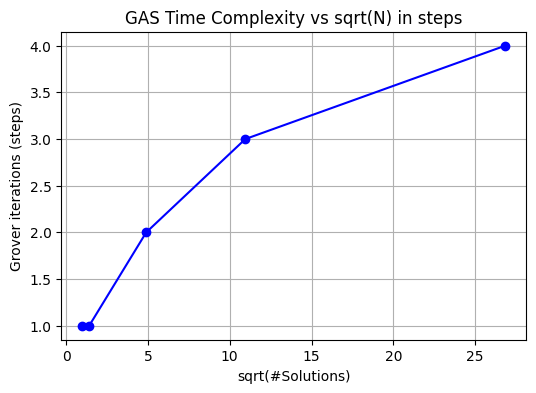


=== Grover Steps Analysis ===
Test case | #Solutions (N) | sqrt(N) | Grover steps
        1 |              1 |    1.00 |            1
        2 |              2 |    1.41 |            1
        3 |             24 |    4.90 |            2
        4 |            120 |   10.95 |            3
        5 |            720 |   26.83 |            4

Empirical fit: steps ≈ 0.115574 * sqrt(N) + 1.157516
This roughly matches the expected O(sqrt(N)) complexity of Grover Adaptive Search.


In [ ]:
# Grover Adaptive Search (GAS) for VRP — Gate-based Qiskit implementation (local simulator)
# - No IBM cloud / API usage
# - Gate-level oracle using multi-controlled-X (mcx) to implement multi-controlled phase flips
# - Suitable for small enumerated VRP instances used in demonstrations
#
# Requirements:
#   pip install qiskit matplotlib numpy
#
# Usage:
#   Edit the `test_cases` list below (small instances only) and run the script.
#   Keep the number of total enumerated solutions manageable (2^n_qubits should be <= a few thousand).

import math
import itertools
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# ----------------------------
# Classical VRP helpers
# ----------------------------
def route_cost(route, dist):
    if not route:
        return 0
    s = dist[0, route[0]]
    for i in range(len(route) - 1):
        s += dist[route[i], route[i + 1]]
    s += dist[route[-1], 0]
    return s

def total_cost(sol, dist):
    return sum(route_cost(route, dist) for route in sol)

def enumerate_complete_solutions(num_customers, num_vehicles):
    city_idx = list(range(1, num_customers + 1))
    solutions = []
    for assign in itertools.product(range(num_vehicles), repeat=num_customers):
        groups = [[] for _ in range(num_vehicles)]
        for cust_idx, v in enumerate(assign):
            groups[v].append(cust_idx + 1)
        perms_list = []
        for g in groups:
            if g:
                perms_list.append(list(itertools.permutations(g)))
            else:
                perms_list.append([()])
        for combo in itertools.product(*perms_list):
            solutions.append(tuple(combo))
    return solutions

# ----------------------------
# Quantum building blocks
# ----------------------------
def build_gate_oracle(qc, data_qubits, ancilla_qubits, marked_index, n_data_qubits):
    if n_data_qubits == 0:
        return
    bitstr = format(marked_index, f'0{n_data_qubits}b')
    for i, b in enumerate(bitstr):
        if b == '0':
            qc.x(data_qubits[i])
    if n_data_qubits == 1:
        qc.z(data_qubits[0])
    else:
        target = data_qubits[-1]
        controls = data_qubits[:-1]
        qc.h(target)
        if len(controls) == 1:
            qc.cx(controls[0], target)
        else:
            if ancilla_qubits:
                qc.mcx(controls, target, ancilla_qubits, mode='basic')
            else:
                qc.mcx(controls, target)
        qc.h(target)
    for i, b in enumerate(bitstr):
        if b == '0':
            qc.x(data_qubits[i])

def build_diffusion(qc, data_qubits, ancilla_qubits):
    n = len(data_qubits)
    if n == 0:
        return
    for q in data_qubits:
        qc.h(q)
    for q in data_qubits:
        qc.x(q)
    if n == 1:
        qc.z(data_qubits[0])
    else:
        target = data_qubits[-1]
        controls = data_qubits[:-1]
        qc.h(target)
        if len(controls) == 1:
            qc.cx(controls[0], target)
        else:
            if ancilla_qubits:
                qc.mcx(controls, target, ancilla_qubits, mode='basic')
            else:
                qc.mcx(controls, target)
        qc.h(target)
    for q in data_qubits:
        qc.x(q)
    for q in data_qubits:
        qc.h(q)

# ----------------------------
# GAS via gate-based circuits
# ----------------------------
def run_gate_gas(num_customers, dist_matrix, num_vehicles=2, shots=1024):
    solutions = enumerate_complete_solutions(num_customers, num_vehicles)
    N = len(solutions)
    if N == 0:
        raise ValueError("No solutions generated.")
    costs = [total_cost(sol, dist_matrix) for sol in solutions]
    min_cost = min(costs)
    optimal_indices = [i for i, c in enumerate(costs) if math.isclose(c, min_cost)]

    n_data_qubits = max(1, math.ceil(math.log2(N)))
    N_states = 2 ** n_data_qubits
    ancilla_qubits = max(0, n_data_qubits - 2)
    total_qubits = n_data_qubits + ancilla_qubits

    qc = QuantumCircuit(total_qubits, n_data_qubits)
    data_qubits = list(range(n_data_qubits))
    ancillas = list(range(n_data_qubits, total_qubits)) if ancilla_qubits > 0 else []

    for q in data_qubits:
        qc.h(q)

    M = max(1, len(optimal_indices))
    r = max(1, int(math.floor((math.pi / 4) * math.sqrt(N_states / M))))
    r = min(r, 30)

    for _ in range(r):
        for opt_idx in optimal_indices:
            build_gate_oracle(qc, data_qubits, ancillas, opt_idx, n_data_qubits)
        build_diffusion(qc, data_qubits, ancillas)

    for i, q in enumerate(data_qubits):
        qc.measure(q, i)

    backend = AerSimulator()
    tqc = transpile(qc, backend=backend, optimization_level=2)
    result = backend.run(tqc, shots=shots).result()
    counts = result.get_counts(qc)

    converted_counts = {}
    for bitstr, cnt in counts.items():
        bs = bitstr.replace(" ", "")
        try:
            idx = int(bs, 2)
        except ValueError:
            idx = int(bs[::-1], 2)
        converted_counts[idx] = converted_counts.get(idx, 0) + cnt

    sorted_counts = sorted(converted_counts.items(), key=lambda kv: kv[1], reverse=True)
    most_valid = None
    for idx, cnt in sorted_counts:
        if idx < N:
            most_valid = (idx, cnt)
            break

    chosen_idx = most_valid[0] if most_valid else None
    chosen_solution = solutions[chosen_idx] if chosen_idx is not None else None
    chosen_cost = costs[chosen_idx] if chosen_idx is not None else None

    res = {
        "n_data_qubits": n_data_qubits,
        "N_states": N_states,
        "num_solutions": N,
        "optimal_indices": optimal_indices,
        "chosen_index": chosen_idx,
        "chosen_solution": chosen_solution,
        "chosen_cost": chosen_cost,
        "counts": converted_counts,
        "grover_iterations": r,
        "circuit": tqc,
        "qc_raw": qc
    }
    return res

# ----------------------------
# Helper for pretty printing solution
# ----------------------------
def format_solution(sol, city_names=None):
    if sol is None:
        return None
    if city_names:
        def conv(route):
            return tuple(city_names[c] for c in route)
        return tuple(conv(r) for r in sol)
    else:
        return tuple(tuple(r) for r in sol)

# ----------------------------
# Main execution: 7 small test cases
# ----------------------------
if __name__ == "__main__":
    test_cases = [
        {"city_names": ["Depot","A"], "num_customers": 1, "dist": np.array([[0,1],[1,0]]), "num_vehicles":1},
        {"city_names": ["Depot","A","B"], "num_customers":2, "dist": np.array([[0,1,2],[1,0,1],[2,1,0]]), "num_vehicles":1},
        {"city_names": ["Depot","A","B","C"], "num_customers":3, "dist": np.array([[0,2,3,1],[2,0,1,2],[3,1,0,2],[1,2,2,0]]), "num_vehicles":2},
        {"city_names": ["Depot","A","B","C","D"], "num_customers":4, "dist": np.array([[0,1,4,3,2],[1,0,2,3,1],[4,2,0,1,2],[3,3,1,0,2],[2,1,2,2,0]]), "num_vehicles":2},
        {"city_names": ["Depot","A","B","C","D","E"], "num_customers":5, "dist": np.array([[0,1,2,3,4,5],[1,0,1,2,3,4],[2,1,0,1,2,3],[3,2,1,0,1,2],[4,3,2,1,0,1],[5,4,3,2,1,0]]), "num_vehicles":2}

    ]

    N_values = []
    grover_steps = []

    for i, case in enumerate(test_cases, start=1):
        print(f"\n=== Test case {i}: {case['num_customers']} customers, {case['num_vehicles']} vehicles ===")
        res = run_gate_gas(case["num_customers"], case["dist"], num_vehicles=case["num_vehicles"])
        N_values.append(res["num_solutions"])
        grover_steps.append(res["grover_iterations"])
        print(f"Number of solutions: {res['num_solutions']}")
        print(f"Grover iterations (steps): {res['grover_iterations']}")
        print(f"Classical optimal indices: {res['optimal_indices']}")
        if res["chosen_solution"] is not None:
            print("Most frequently measured valid index:", res["chosen_index"])
            print("Decoded solution (vehicle routes):", format_solution(res["chosen_solution"], case["city_names"]))
            print("Classical cost of that solution:", res["chosen_cost"])

    # ----------------------------
    # Plot Grover steps vs sqrt(N)
    # ----------------------------
    sqrtN = [math.sqrt(n) for n in N_values]
    plt.figure(figsize=(6,4))
    plt.plot(sqrtN, grover_steps, 'o-', color='blue')
    plt.xlabel("sqrt(#Solutions)")
    plt.ylabel("Grover iterations (steps)")
    plt.title("GAS Time Complexity vs sqrt(N) in steps")
    plt.grid(True)
    plt.show()

    # ----------------------------
    # Print table and rough complexity
    # ----------------------------
    print("\n=== Grover Steps Analysis ===")
    print("Test case | #Solutions (N) | sqrt(N) | Grover steps")
    for i in range(len(N_values)):
        print(f"{i+1:9d} | {N_values[i]:14d} | {sqrtN[i]:7.2f} | {grover_steps[i]:12d}")

    # Linear fit for rough check
    coeffs = np.polyfit(sqrtN, grover_steps, 1)
    print(f"\nEmpirical fit: steps ≈ {coeffs[0]:.6f} * sqrt(N) + {coeffs[1]:.6f}")
    print("This roughly matches the expected O(sqrt(N)) complexity of Grover Adaptive Search.")
